In [53]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 27 14:34:20 2017
This is a small project for CNN in KERAS.
This file creates, trains and save a convolutional neural network for
Human Acitivity Recognition. The data we used for this file is released and provided by
Wireless Sensor Data Mining (WISDM) lab and can be found on this link.
http://www.cis.fordham.edu/wisdm/dataset.php  
Feel free to use this code and site this repositry if you use it for your reports or project.
@author: Muhammad Shahnawaz
"""
# importing libraries and dependecies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
#from keras import backend as K
from tensorflow.keras import optimizers
#K.set_image_dim_ordering('th')
# setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

# matplotlib inline
plt.style.use('ggplot')
# defining function for loading the dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis','x-rotate','y-rotate','z-rotate','arms','rrms','roll','pitch']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data
# defining a function for feature normalization
# (feature - mean)/stdiv
def featureNormalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset-mu)/sigma
# defining the function to plot a single axis data
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)
# defining a function to plot the data for a given activity
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(nrows=10, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plotAxis(ax3,data['timestamp'],data['x-rotate'],'x-rotate')
    plotAxis(ax4,data['timestamp'],data['y-rotate'],'y-rotate')
    plotAxis(ax5,data['timestamp'],data['z-rotate'],'z-rotate')
    plotAxis(ax6,data['timestamp'],data['arms'],'arms')
    plotAxis(ax7,data['timestamp'],data['rrms'],'rrms')
    plotAxis(ax8,data['timestamp'],data['roll'],'roll')
    plotAxis(ax9,data['timestamp'],data['pitch'],'pitch')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()
# defining a window function for segmentation purposes
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)
# segmenting the time series
def segment_signal(data, window_size = 20):
    segments = np.empty((0,window_size,10))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        a = data['x-rotate'][start:end]
        b = data['y-rotate'][start:end]
        c = data['z-rotate'][start:end]
        d = data['arms'][start:end]
        e = data['rrms'][start:end]
        f = data['roll'][start:end]
        g = data['pitch'][start:end]
        if(len(data['timestamp'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z,a,b,c,d,e,f,g])])
            labels = np.append(labels,stats.mode(data['activity'][start:end])[0][0])
    return segments, labels
''' Main Code '''
# # # # # # # # #   reading the data   # # # # # # # # # # 
# Path of file #

#dataset = readData('TEST_xin_all_col_13.txt')
#dataset = readData('TEST_mz_squat_situp_col_13.txt')
#dataset = readData('TEST_ljy_pushup_squat.txt')
dataset = readData('TEST_ljy_pushup_situp_squat.txt') # TEST_ljy_pushup_situp_squat.txt 파일에 xin situp 추가한 파일
#dataset = readData('TEST_ljy_pushup_situp_squat-test.txt') 




In [54]:
print(dataset['activity'])
print('pushup : ',dataset['activity'].tolist().count('pushup'))
print('situp : ',dataset['activity'].tolist().count('situp'))
print('squat : ',dataset['activity'].tolist().count('squat'))

0        squat
1        squat
2        squat
3        squat
4        squat
         ...  
4154    pushup
4155    pushup
4156    pushup
4157    pushup
4158    pushup
Name: activity, Length: 4159, dtype: object
pushup :  1771
situp :  57
squat :  2331


In [55]:
# plotting a subset of the data to visualize
for activity in np.unique(dataset['activity']):
    subset = dataset[dataset['activity']==activity][:180]
    """plotActivity(activity,subset)""" #그림그리는거
# segmenting the signal in overlapping windows of 90 samples with 50% overlap

segments, labels = segment_signal(dataset) # window size에 다가 50% 중첩이므로 totaldata/(windowsize/2)의 개수를 가진다 
print(len(segments), len(labels))

#categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)
#print(labels)

# defining parameters for the input and network layers
# we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# split ratio for test and validation
trainSplitRatio = 0.8
# number of epochs
Epochs = 10
# batchsize
batchSize = 10
# number of total clases
numClasses = labels.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2
# reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)


# splitting in training and testing data
#trainSplit = np.random.rand(len(reshapedSegments)) < trainSplitRatio
#trainX = reshapedSegments[trainSplit]

testX = reshapedSegments
testX = np.nan_to_num(testX)


testY = labels
#print(testY)

np.save('groundTruth.npy',testY)
np.save('testData.npy',testX)


414 414


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 9, 128)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 4, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3

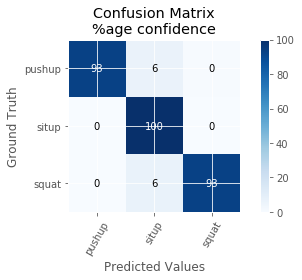

In [56]:
# importing the dependencies
from tensorflow.keras.models import load_model
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import os
# defining a function for plotting the confusion matrix
# takes cmNormalized
os.environ['QT_PLUGIN_PATH'] = ''
def plot_cm(cM, labels,title):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig(title +'.png')
# loading the pretrained model
model = load_model('model.h5')
model.summary()
#loading the testData and groundTruth data
test_x = np.load('testData.npy')
groundTruth = np.load('groundTruth.npy')
# evaluating the model


#score = model.evaluate(test_x,groundTruth,verbose=2)
#print('Baseline Error: %.2f%%' %(100-score[1]*100))
'''
 Creating and plotting a confusion matrix

'''
# defining the class labels
#labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
labels = ['pushup','situp','squat']
#labels = ['situp','squat']
# predicting the classes
predictions = model.predict(test_x,verbose=2)


xxx = model.predict_classes(test_x)
print('predict',xxx)
print(len(xxx))

answer=[]
for i in groundTruth:
    answer.append(*np.where(i==1)[0])
print('answer',answer)
print(len(answer))




# getting the class predicted and class in ground truth for creation of confusion matrix
predictedClass = np.zeros((predictions.shape[0]))
groundTruthClass = np.zeros((groundTruth.shape[0]))
for instance in range (groundTruth.shape[0]):
    predictedClass[instance] = np.argmax(predictions[instance,:])
    groundTruthClass[instance] = np.argmax(groundTruth[instance,:])

# obtaining a confusion matrix  
cm = metrics.confusion_matrix(answer,xxx)
#cm = metrics.confusion_matrix(groundTruthClass,xxx)
#cm = metrics.confusion_matrix(groundTruthClass,predictedClass) # 이게 원래
# plotting the confusion matrix
plot_cm(cm, labels,'Confusion Matrix')